At the end of this notebook, we will have submitted to the ["Paddy Doctor: Paddy Disease Classification" competition on Kaggle](https://www.kaggle.com/competitions/paddy-disease-classification/overview)!

Let us begin by downloading the data.

In [1]:
%%bash

exec bash
# rm -rf data
# mkdir data
apt install unzip


Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 1s (334 kB/s)
Selecting previously unselected package unzip.
(Reading database ... 44825 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.1) ...
Setting up unzip (6.0-21ubuntu1.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...




debconf: delaying package configuration, since apt-utils is not installed


In [2]:
pip install -U timm

     |████████████████████████████████| 431 kB 20.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!cd data && kaggle competitions download -c paddy-disease-classification && unzip -q paddy-disease-classification.zip

paddy-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test_images/200001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import timm

We have now downloaded and extracted the data to the `data` directory.

In [2]:
ls data

paddy-disease-classification.zip  test_images/  train_images/
sample_submission.csv             train.csv


In [3]:
ls data/train_images

bacterial_leaf_blight/     blast/       downy_mildew/  tungro/
bacterial_leaf_streak/     brown_spot/  hispa/
bacterial_panicle_blight/  dead_heart/  normal/


In [4]:
ls data/test_images | head

200001.jpg
200002.jpg
200003.jpg
200004.jpg
200005.jpg
200006.jpg
200007.jpg
200008.jpg
200009.jpg
200010.jpg
ls: write error: Broken pipe


Seems that the train data is organized by directories, with the name of the directory being the label.

Test images just live in `data/test_images`

Let us see what is the format of the sample submission file to have a full picture.

In [5]:
import pandas as pd

sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


Mhmm. Guessing the labels for the submission are the names of the directories.

Ok, let's start training!

In [6]:
from fastai.vision.all import *

I am going through the `01_intro.ipynb` notebook and it seems the files in the example there are organizedin a different way than the files here 🤔

Well, but I have the handy `doc` function! I bet it can give me a suggestion on how to approach this!

I see that this `ImageDataLoaders` is used... I run `doc` on it and click `Show in docs` to read a bit more about this in my browser.

In [7]:
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

Well, the `from_path_re` class method seems interesting. Maybe I can get it to work.

In [8]:
fns = get_image_files('data/train_images/')
fns # looks about right!

(#10407) [Path('data/train_images/bacterial_panicle_blight/109162.jpg'),Path('data/train_images/bacterial_panicle_blight/109183.jpg'),Path('data/train_images/bacterial_panicle_blight/101765.jpg'),Path('data/train_images/bacterial_panicle_blight/101592.jpg'),Path('data/train_images/bacterial_panicle_blight/104770.jpg'),Path('data/train_images/bacterial_panicle_blight/110190.jpg'),Path('data/train_images/bacterial_panicle_blight/106643.jpg'),Path('data/train_images/bacterial_panicle_blight/104269.jpg'),Path('data/train_images/bacterial_panicle_blight/108023.jpg'),Path('data/train_images/bacterial_panicle_blight/107676.jpg')...]

Now let me experiment with just a single path and a regex pattern.

In [9]:
import re

In [10]:
str(fns[0])

'data/train_images/bacterial_panicle_blight/109162.jpg'

In [11]:
pat = r'/([^/]*)/\d+.jpg$'
re.search(pat, str(fns[0])).group(1)

'bacterial_panicle_blight'

Well, this seems to work. Only way to find out is to try!

And don't worry about the regex. I copied it from the docs 😄 I don't mind writing regexes, expecially with useful [tools around](https://pythex.org/) but I always, ALWAYS have to google the API. Is it `search` or `match`? How do the groups work? Oh dear...

Anyhow

In [12]:
dls = ImageDataLoaders.from_path_re('data', fns, pat, item_tfms=Resize(224,298), bs=48, val_bs=48)

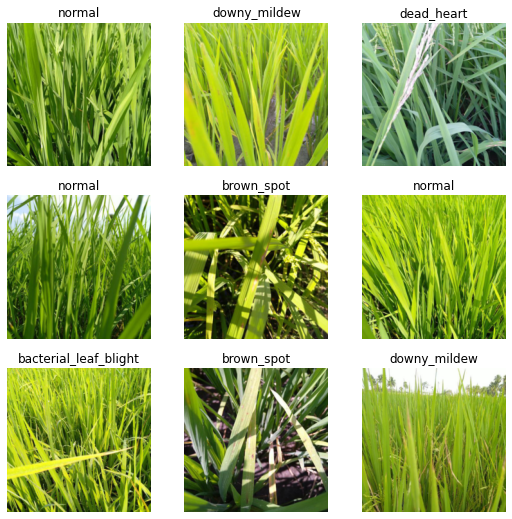

In [13]:
dls.train.show_batch()

Looks like it worked! 🥳

In [14]:
len(dls.train), len(dls.valid)

(173, 44)

In [15]:
dls.bs

48

In [16]:
dls.valid.bs

48

I am just clicking around, learning about the objects I got returned! Marvelous!

Let's train.

In [17]:
import timm

In [18]:
timm??

Type:        module
String form: <module 'timm' from '/opt/conda/lib/python3.7/site-packages/timm/__init__.py'>
File:        /opt/conda/lib/python3.7/site-packages/timm/__init__.py
Source:     
from .version import __version__
from .models import create_model, list_models, is_model, list_modules, model_entrypoint, \
    is_scriptable, is_exportable, set_scriptable, set_exportable, has_model_default_key, is_model_default_key, \
    get_model_default_value, is_model_pretrained


In [17]:
timm.list_models("convnext*")

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [18]:
learn = vision_learner(dls, 'convnext_base_in22k', metrics=error_rate)
learn.fine_tune(14)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.245158,0.707314,0.239308,03:15


epoch,train_loss,valid_loss,error_rate,time
0,0.702090,0.459090,0.145123,12:19
1,0.525045,0.374526,0.113407,12:16
2,0.412207,0.288772,0.092744,12:17
3,0.331099,0.227147,0.070159,12:18
4,0.220998,0.197792,0.065353,12:17
5,0.181341,0.186134,0.058626,12:18
6,0.152170,0.187127,0.055262,12:18
7,0.114464,0.150768,0.041807,12:19
8,0.088391,0.148253,0.037001,12:18
9,0.065617,0.140882,0.035079,12:19


Well, that seems like a surprisingly good performance given how challenging the task seems 🤔

Let's see how we can obtain predictions from our model.

In [ ]:
preds = learn.get_preds()

In [ ]:
preds

(TensorBase([[5.7801e-08, 8.1908e-07, 2.6466e-07,  ..., 1.5330e-05, 9.9998e-01,
          5.4904e-07],
         [9.9912e-01, 8.2472e-06, 5.9034e-06,  ..., 6.7669e-05, 2.6667e-05,
          6.5043e-04],
         [4.8992e-08, 6.5597e-09, 1.9013e-05,  ..., 1.3332e-08, 2.3999e-09,
          1.4693e-07],
         ...,
         [2.2542e-09, 2.8985e-06, 9.2130e-10,  ..., 5.0098e-13, 2.0083e-12,
          1.0000e+00],
         [1.9061e-07, 4.0809e-06, 1.3393e-04,  ..., 5.1865e-07, 2.0323e-05,
          1.6777e-07],
         [9.9195e-01, 1.5861e-03, 5.4277e-05,  ..., 7.7996e-05, 1.0999e-03,
          2.0757e-06]]),
 TensorCategory([8, 0, 5,  ..., 9, 5, 0]))

In [ ]:
preds[0][0].sum(), preds[0][0].max()

(TensorBase(1.0000), TensorBase(1.0000))

Looks like preds maybe holds class probabilities and label idxs? But where do I get the labels from?!

In [ ]:
learn.dls.c

10

Mhmm, that's not it.

In [ ]:
doc(ImageDataLoaders)

In [ ]:
learn.dls.train_ds.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

After a bit of searching, I found where the category names are stored!

Now we need to predict on our test items!

In [ ]:
test_dl = learn.dls.test_dl(get_image_files('data/test_images'))

In [ ]:
test_preds = learn.get_preds(dl=test_dl)

In [ ]:
sample_sub

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [ ]:
get_image_files('data/test_images')

(#3469) [Path('data/test_images/200770.jpg'),Path('data/test_images/203307.jpg'),Path('data/test_images/203265.jpg'),Path('data/test_images/201796.jpg'),Path('data/test_images/202973.jpg'),Path('data/test_images/201780.jpg'),Path('data/test_images/201052.jpg'),Path('data/test_images/201179.jpg'),Path('data/test_images/201783.jpg'),Path('data/test_images/200080.jpg')...]

In [ ]:
predicted_classes = [learn.dls.train_ds.vocab[i] for i in test_preds[0].argmax(1)]

In [ ]:
predicted_classes[:10]

['bacterial_leaf_streak',
 'blast',
 'dead_heart',
 'bacterial_leaf_blight',
 'downy_mildew',
 'hispa',
 'brown_spot',
 'tungro',
 'normal',
 'dead_heart']

And the last thing we need to output predictions are file names.

In [ ]:
fns = [p.name for p in get_image_files('data/test_images')]

In [ ]:
sub = pd.DataFrame(data={'image_id': fns, 'label': predicted_classes})

In [ ]:
mkdir data/submissions

In [ ]:
sub.to_csv('data/submissions/brismith_sub1.csv.gz', index=False)

In [ ]:
!kaggle competitions submit -c paddy-disease-classification -f data/submissions/brismith_sub1.csv.gz -m "1st sub convnext base"

100%|██████████████████████████████████████| 11.6k/11.6k [00:00<00:00, 24.1kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification